In [118]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import v2

torch.__version__

'2.2.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1.Loading dataset


In [4]:
# Image Transformation function using torchvision.transforms
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ]
)

In [5]:
# data is loaded from directory with automatic labeling for different subfolder
data_dir = "data/vehicle_images"
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [6]:
from torch.utils.data import random_split

# Splitting test and train data size from dataset object
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
from torch.utils.data import DataLoader

# Looading the data from the dataset objects
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Specifying names for labels
class_names = {0: "four wheeler", 1: "two wheeler"}

In [9]:
# Separating features and labels into different tensors from the dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_labels_batch

tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])

In [10]:
train_features_batch[0].shape

torch.Size([3, 224, 224])

## 2.Visualizing random sample from the training dataset


Image size: torch.Size([3, 224, 224])
Label: 1, label size: torch.Size([])


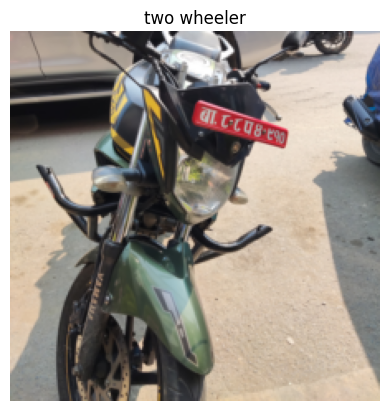

In [11]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(
    img.permute(
        1, 2, 0
    )  # Matplotlib only accepts img matrix in shape HeightxWidthxColor, Pytorch tensor in ColorxHeightxWidth
)
plt.title(class_names[label.item()])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Defining CNN for Image Classification


In [91]:
class VehicleClassifier(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=1,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 56 * 56, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        # UNCOMMENT THE PRINT SHAPES TO FIND OUT CLASSIFIER INPUT FEATURE SHAPE
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)

        return x

### Creating model with class initialization


In [102]:
torch.manual_seed(42)
# Output shape = 1 for BCE, 2 for CrossEntropy



model = VehicleClassifier(input_shape=3, hidden_units=32, output_shape=2).to(device)

In [103]:
# To check input features of classifier layer
# First, uncomment print(x.shape) lines in forward method
model(img.unsqueeze(0).to(device))

tensor([[0.0200, 0.0084]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 4.Setting up acc/optimizer/loss


In [104]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 5. Train/test loop


### Function


In [105]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
    isBCE: bool = False,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for X, y in data_loader:

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # print(f"pred shape: {y_pred.shape},y shape:{ y.shape}")

        # 2. Calculate loss
        # if isBCE:
        #     loss = loss_fn(y_pred.squeeze(1), y.float())
        #     train_acc += accuracy_fn(
        #         y_true=y,
        #         y_pred=torch.sigmoid(y_pred.squeeze(1)).round(),
        #     )
        # else:  # CrossEntropyLoss
        loss = loss_fn(y_pred, y)

        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # Go from logits -> pred labels
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
    isBCE: bool = False,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            # if isBCE:
            #     test_loss += loss_fn(test_pred.squeeze(1), y.float())
            #     test_acc += accuracy_fn(
            #         y_true=y,
            #         y_pred=torch.sigmoid(test_pred.squeeze(1)).round(),
            #     )
            # else:  # CrossEntropyLoss
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),  # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [107]:
torch.manual_seed(42)
# Train and test model
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        isBCE=False,
    )

Epoch: 0
---------
Train loss: 0.46726 | Train accuracy: 78.94%
Test loss: 0.44216 | Test accuracy: 85.62%

Epoch: 1
---------
Train loss: 0.43075 | Train accuracy: 81.37%
Test loss: 0.40149 | Test accuracy: 86.75%

Epoch: 2
---------
Train loss: 0.34637 | Train accuracy: 86.28%
Test loss: 0.47166 | Test accuracy: 84.38%



## 6. Evaluating on unseen images


In [110]:
new_dir = "data/unseen"
unseen_dataset = datasets.ImageFolder(new_dir, transform=transform)
len(unseen_dataset)

20

In [111]:
unseen_loader = DataLoader(
    unseen_dataset,
    shuffle=False,
)

### Creating a Prediction function for Test Samples


In [112]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)  # Add an extra dimension for batch

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # Perform softmax on the channel dimension

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.cat(pred_probs, dim=0)

### Getting Test samples/labels separately from Unseen_loader


In [113]:
test_samples = []
test_labels = []
for sample, label in unseen_loader:
    test_samples.append(sample)
    test_labels.append(label.item())
sample.shape

torch.Size([1, 3, 224, 224])

### Making predictions for test samples


In [115]:
pred_probs = make_predictions(model=model, data=test_samples)
# View first two prediction probabilities list
# Converting prediction probabilities into labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

### Visualizing our predictions on Unseen data


In [116]:
# Calculating accuracy of prediction on new images
correct = 0
total = 0
with torch.no_grad():
    for images, labels in unseen_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on new images: {accuracy:.2f}%")

Accuracy on new images: 65.00%


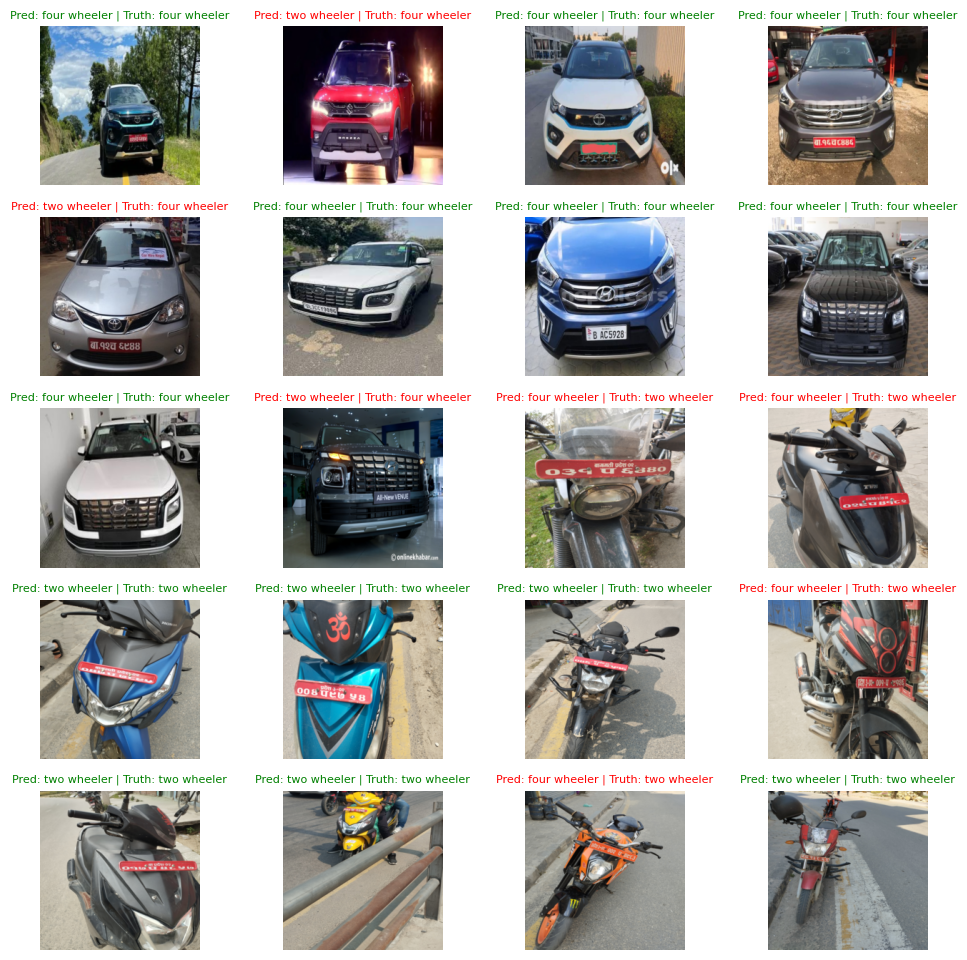

In [117]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 5
ncols = 4
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    sample = sample.squeeze()
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_labels[i].item()]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=8, c="r")  # red text if wrong
    plt.axis(False)